## PFFP Code Intro

The purpose of this notebook is to detail the features and steps to process PFFP binary code information.

Date: 09/09/2024

Name: Jonathan Moore

## Library/Module importing

This step is so that the libraries required can be accessed by the local code

In [1]:
import matplotlib.pyplot as plt
import sys
import os
import numpy as np

#### Add the BlueDrop Analysis library to the current path
This is necessary for the time being since the library hasn't been converted a python package yet

In [2]:
sys.path.append("../../BlueDrop_Analysis_Lib")

### Local Imports
These are imports from the actual BlueDrop Analysis Lib that our team wrote

In [3]:
# Local loads

# This class represent the Folder that contains the pffp data
from lib.data_classes.pffpFolder import pffpDataFolder

### Set the necessary paths
These paths will be used to retrieve the data, dimensions of the BlueDrop, and Calibration Data


In [4]:
# Data folder
# folder_dir = r"C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\stark_drops"
folder_dir = os.path.join(os.pardir, "Mouth_1")

# PFFP sensor data
calibration_dir = os.path.join(os.pardir, "calibration_factors/BlueDrop_Calibration_Factors.xlsx")

# PFFP tip information
tip_dir = os.path.join(os.pardir, "calibration_factors/BluedDrop_Cone_Values.xlsx")


### Creating the pffp Data folder

The purpose of the next cell is to create the ```pffp_data_folder``` and load the correct calibration factors to convert the voltages measured by the BlueDrop sensors to engineering units (g's, meters, pressure (kPa))

In [5]:
# Set the name for the survey 
name = "VIM_Mouth_1"

# Set the id for the pffp
id = 3

# Create the object that will represent the folder with the pffp data in it
pffp_data_folder = pffpDataFolder(folder_dir, pffp_id = id, calibration_factor_dir=calibration_dir, survey_name = name)

# Read the calibration data
pffp_data_folder.read_calibration_excel_sheet()

# Select the specific calibration params
if id == 3:
    pffp_data_folder.get_sensor_calibration_params("Sequim_2021")
elif id == 1:
    pffp_data_folder.get_sensor_calibration_params("March_2023")
elif id ==9:
    pffp_data_folder.get_sensor_calibration_params("October_2023")
else:
    raise ValueError("not a valid pffp id")


#### Display the selected calibration factors

In [6]:
display(pffp_data_folder.calibration_excel_sheet)

,Sensor,Sequim_2021_offset,Sequim_2021_scale
0,2g_accel,-34426.50,1615925.8
1,18g_accel,12322.10,163530.7
2,50g_accel,-244513.80,63651.0
3,200g_accel,-262332.40,38888.7
4,250g_accel,-40536.10,13631.6
5,55g_x_tilt,-59093.70,66674.3
6,55g_y_tilt,-140224.60,66674.3
7,pore_pressure,-51617.54,20705.0


### Find all the pffp files

The next cell finds all the pffp files and stores a reference to them. The way it does this is by searching to find all the ```.bin``` files in the folder. As such, make sure there are no other files in the folder that have a ```.bin``` file extension.

In [7]:
# Init a pffpFile instances for each binary file and store the results in the folder
pffp_data_folder.store_pffp_files(recursive = False)

# Print Meta-data about the pffp_data_folder including the number of .bin files found.
print(pffp_data_folder) # Information about the folder

Folder: ..\Mouth_1 
Date range: Not set 
PFFP id: 3                 
Calibration Param dir: ..\calibration_factors/BlueDrop_Calibration_Factors.xlsx 
Num .bin files: 8                 
Num files with drops: Not Set


### Analyze the files

The purpose of this step is to determine which files have drops in them. 

The possible scenarios are:

#### Drop in file
If the code unequivocally finds all the drops in the file, then the reference to the file object is stored in the ```pffp_drop_files``` list. 

#### No Drop in file
If the code unequivocally finds no drops in the file, then the reference to the file object is stored in the ```pffp_no_drop_files``` list. Additionally, the actual ```.bin``` file is moved into a subdirectory of the current working folder, that will contain the files that don't have drops in them. The default name for this folder is ```no_drop_folder```

#### Code can't figure out if there's a drop or not
When the code can't determine if the file does or does not contain a drop, the files are treated as "funky" files. Similar to the "no drop" files the funky files have their actual '''.bin''' file moved into a subdirectory of the current working folder. The name for this folder is ```funky_folder```. 

#### Accessing the lists that contain the different file types
Given that the folder object in this example is called ```pffp_data_folder```, the different lists can be accessed in the following ways:

* Files that unequivocally contain drops       : ```pffp_data_folder.pffp_drop_files```
* Files that unequivocallyt don't contain drops: ```pffp_data_folder.pffp_no_drop_files```
* Files that have a funky status               : ```pffp_data_folder.pffp_funky_files```


In [8]:
# Figures out if the .bin file has a drop
pffp_data_folder.analyze_all_files(store_df=True, use_pore_pressure=True, 
                              select_accel=["2g_accel", "18g_accel", "50g_accel", "250g_accel"],
                              debug = False)

Folder '..\Mouth_1\no_drop_folder' already exists.
Folder '..\Mouth_1\funky' already exists.

Progress finding files with drops...
[==================================================] 100.00% ETA (min): 0.0
Initial analysis complete!


### Processing Drop Files

The next cell processes the files that unequivocally have drops in them.

This means that for each drop in each file that contains a drop the following are done:

* An object is created to represent each drop 
* The start and end of the drop are found
* The acceleration data is integrated to get the velocity and displacement

In [9]:
# Figure out the beginning and the end of the drops if the files contain drops
pffp_data_folder.process_drop_files()


Progress processing drops in files...
[======--------------------------------------------] 12.50% ETA (min): 1.7e-08

[==================================================] 100.00% ETA (min): 1.7e-08

### Processing Funky Files

For funky files there's at least one drop in the file that the code isn't sure if it's a drop or not. As such, those files need to be processed by hand. The following cell details the steps that are necessary to do that.

If the code doesn't find any funky files that this step isn't necessary.

In [10]:
# Steps to process funky files

# Loop over all the files that are funky
for file in pffp_data_folder.pffp_funky_files:

    # Manual Process the drop. This method will take you through the process of manually processing the drop
    file.manually_process_drops(interactive_plot=True)

### Print out folder metadata

Printing out the folder meta-data again to see how it's been updated.

In [11]:
# Print information about the folder object
print(pffp_data_folder)

Folder: ..\Mouth_1 
Date range: Not set 
PFFP id: 3                 
Calibration Param dir: ..\calibration_factors/BlueDrop_Calibration_Factors.xlsx 
Num .bin files: 8                 
Num files with drops: 8


## Info on the next section

The following cells walk using the prebuilt plotting functions for files and drops. For simplicity instead referencing an element of the ```pffp_data_folder.pffp_drop_files``` list (eg. ```pffp_data_folder.pffp_drop_files[0]```) the file object will be stored in a variable named ```file```. Similary, instead of referring to a drop inside of ```pffp_data_folder.pffp_drop_files[i].drops[j]``` where ```i``` can range from 0 to the number of drop files minus one and ```j``` can range from 0 to the number of drops inside that specific file, the drop object will be stored in a variable named ```drop```. 

### Exploring the pffpFile object

In [12]:
# Store the first drop file

# The load order is different on windows and linux. For the purpose of this demonstration make sure the same file and drop is selected

# Set the indices for the file, drop indices

if os.name == "nt":
    # windows computer
    file_index, drop_index = 0, 0
elif os.name == "posix":
    # Linux computer
    file_index, drop_index = -2, 0 

file = pffp_data_folder.pffp_drop_files[file_index]

# Store the first drop
drop = pffp_data_folder.pffp_drop_files[file_index].drops[drop_index]


### Looking into the ```file```


### Printing the file meta-data

In [13]:
print(file)

File Directory: ..\Mouth_1\..\Mouth_1\bLog0D2F.bin 
Num Drops in file: 1                 
Drop Date: 2024-09-09 
Drop Time: 10:30:51.661815                 
df stored: True                
Concat accel stored: True


#### View the ```.bin``` file as a pandas dataframe (df)

In [14]:
file.df

,Time,2g_accel,18g_accel,50g_accel,pore_pressure,200g_accel,55g_x_tilt,55g_y_tilt,250g_accel
0,0.000000,1.158287,1.155686,1.051377,6.055754,1.406234,0.068352,0.085721,1.110060
1,0.000008,1.156603,1.154347,1.033844,6.207935,1.398365,0.128195,0.042241,1.168528
2,0.000017,1.156164,1.152115,1.068235,6.140003,1.393119,0.156647,0.051780,1.039122
3,0.000025,1.156844,1.150090,1.059688,6.402074,1.400988,0.128570,0.086636,0.988505
4,0.000033,1.153441,1.152047,1.068219,5.843633,1.399857,0.132454,0.049215,1.090840
...,...,...,...,...,...,...,...,...,...
119995,0.999967,1.147635,1.139725,1.143881,47.921482,1.390805,0.019532,0.044341,1.048659
119996,0.999975,1.153472,1.143951,1.103898,48.026377,1.393376,0.003799,0.052620,1.204694
119997,0.999983,1.153645,1.144942,1.105563,48.563173,1.392219,0.005839,0.041821,1.133535
119998,0.999992,1.153616,1.147259,1.105846,47.884186,1.395099,0.011733,0.047731,1.082624


#### Manually plotting sensor information

In [15]:
# View the units that the file.df columns are in
file.sensor_units


{'accel': 'g', 'pressure': 'kPa', 'Time': 'min'}

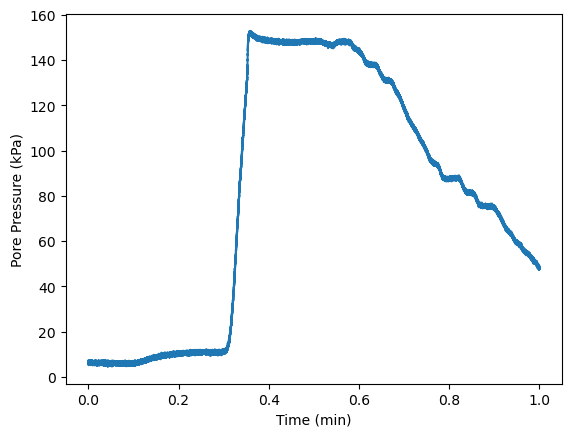

In [16]:
# Store the units for the plot label
time_unit = file.sensor_units["Time"]
pressure_unit = file.sensor_units["pressure"]

# Plot the pressure data
plt.plot(file.df["Time"], file.df["pore_pressure"])
plt.xlabel(f"Time ({time_unit})")
plt.ylabel(f"Pore Pressure ({pressure_unit})")

plt.show()

#### Automatically plot the file and all the sensors

When appended to a file object ```.quick_view()``` plots the time series for each of the sensors. If ```interactive = True``` is set than the plot is interactive. Interactive plots take longer to load than non-interactive plots.

Commonly I use this plot to:

* Check that the code is identifying that the number of drops detected by the code matches what I see
* Get a general impression for what the drops look like and what the pressure response looks like
* Use the interactive plot to look at how well the sensors are calibrated. To find the start and stop of the drops the acceleration data from each of the accelerometers are "stiched" together. This means that at each data point the sensor that has the best resolution for that acceleration is used. For example if the highest acceleration from any of the sensors is measured to be 15 g's then the 18g accelerometer is trusted for that data. However, there are occasions when the 18g sensor might not be calibrarted correctly. Ploting the file data can help you see that.

**Note**: If a sensor isn't calibrated correctly the current solution is to remove it from the stitching process by not including it in the ```pffpfolder``` creating statement. For example if the 200g accelerometer isn't calibrated correctly instead of creating the folder using:

```python
pffp_data_folder.analyze_all_files(store_df=True, use_pore_pressure=True, 
                              select_accel=["2g_accel", "18g_accel", "50g_accel", "200g_accel", "250g_accel"],
                              debug = False)
```

Use:

```python

pffp_data_folder.analyze_all_files(store_df=True, use_pore_pressure=True, 
                              select_accel=["2g_accel", "18g_accel", "50g_accel", "250g_accel"],
                              debug = False)

```
where ```"200g_accel"``` has been removed from the ```selected_accel``` list

In [17]:
# Plot the whole file
file.quick_view(interactive=True, legend=True, figsize=(8, 6))

### Exploring the ```Drop``` object

```Drop``` objects contain direct information about a single drop in a file.

Note:
* Acceleration data in the drop object includes a 1g offset down. This is so the integration of the kinematics can be done correctly.

#### Print the drop meta-data

In [173]:
print(drop)

----- Drop Info ----- 
Containing file: bLog0D2F.bin 
File Drop Index: 1 
Water Drop: None            
Drop indices: {'release_index': np.int64(35278), 'start_impulse_index': np.int64(42125), 'end_impulse_index': np.int64(42537)} 
Processed: True 
Manually Processed: False


#### View the ```impulse_df```

The ```impulse_df``` contains the kinematics of the drop during the impact.

In [174]:
drop.impulse_df

,Time,accel,velocity,displacement
42125,21.062676,0.552564,4.227737,-0.000000
42126,21.063176,0.561103,4.227459,0.002114
42127,21.063676,0.627774,4.227161,0.004227
42128,21.064176,0.653584,4.226841,0.006341
42129,21.064676,0.615242,4.226524,0.008454
...,...,...,...,...
42532,21.266177,1.450775,-0.199696,0.498047
42533,21.266677,1.136930,-0.200343,0.497947
42534,21.267177,0.787795,-0.200824,0.497847
42535,21.267677,0.491336,-0.201144,0.497746


#### View the ```release_df```

The ```release_df``` contains the kinematics during the entire drop (ie. from release until the end of impact)

In [175]:
drop.release_df

,Time,accel,velocity,displacement
35278,17.639147,-0.473753,0.000000,0.000000e+00
35279,17.639647,-0.510366,-0.000246,-6.150842e-08
35280,17.640147,-0.533876,-0.000507,-2.497914e-07
35281,17.640647,-0.541626,-0.000776,-5.705606e-07
35282,17.641147,-0.536880,-0.001046,-1.025957e-06
...,...,...,...,...
42532,21.266177,1.450775,0.199696,-1.340128e+01
42533,21.266677,1.136930,0.200343,-1.340118e+01
42534,21.267177,0.787795,0.200824,-1.340108e+01
42535,21.267677,0.491336,0.201144,-1.340098e+01


#### Plotting the kinematics of the entire drop

This plot goes from the point of release to the point the drop ends.

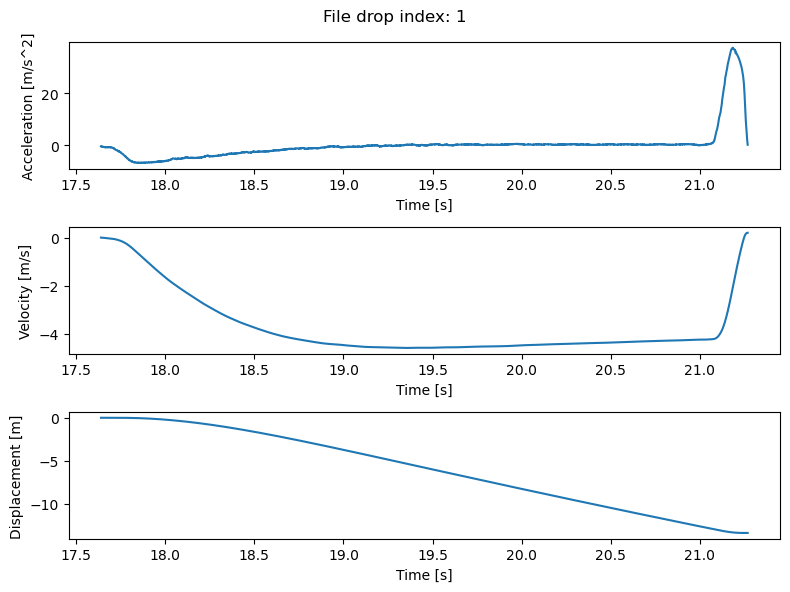

In [176]:
drop.quick_view_release(interactive=False, legend=False, figsize = (8, 6))

#### Plotting the kinematics of the impact (impulse)

Plots the drop kinematics just during the impact.

s


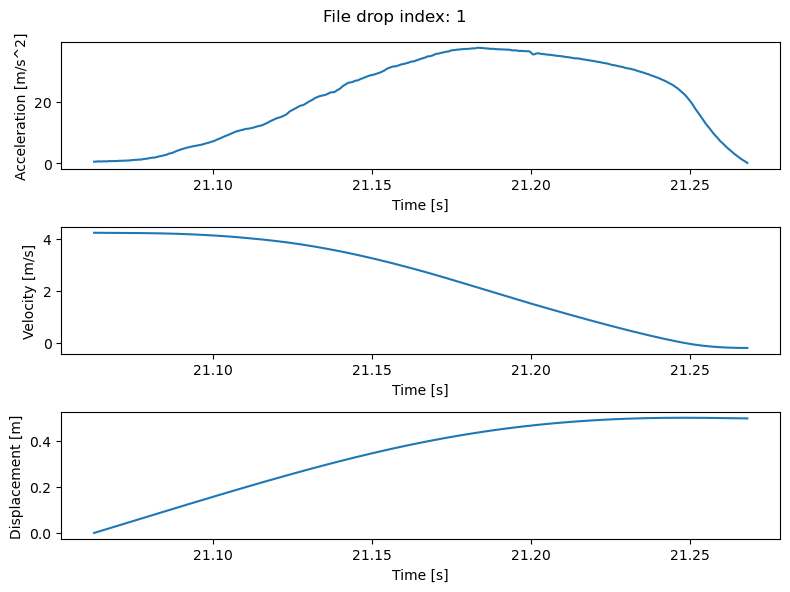

In [177]:
drop.quick_view_impulse(interactive=False, legend = False, figsize = (8, 6))

#### Plot the impulse selection

This plots a comparison of the part of the drop identified as the impact (impulse) and some of the drop on either end.

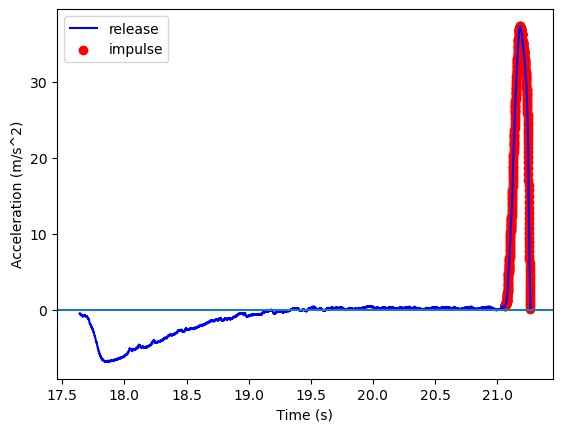

In [178]:
drop.quick_view_impulse_selection(offset = 10000, legend = True, draw_line = True, line_val = 0)

In [179]:
print(drop)

----- Drop Info ----- 
Containing file: bLog0D2F.bin 
File Drop Index: 1 
Water Drop: None            
Drop indices: {'release_index': np.int64(35278), 'start_impulse_index': np.int64(42125), 'end_impulse_index': np.int64(42537)} 
Processed: True 
Manually Processed: False


#### Set the pffp config for the drop

As the pffp config can change drop to drop. The settings need to be set for each drop individually. This could be done as a loop over all the drops if they have have the same configuration.

In [180]:
pffp_id = pffp_data_folder.pffp_id
drop.get_pffp_tip_values(pffp_id=pffp_id, tip_type="cone", date_string = "April_2024", file_dir = tip_dir)

drop.water_drop = 1


In [181]:

# Convert the tip values from the ones in the excel sheet to the ones used in the analysis
drop.convert_tip_vals()

#### Print the information about the tip configuration for the drop

In [182]:
# Print the cone type
print(f"Cone type: {drop.pffp_config["tip_type"]}")

# Display the tip props df
display(drop.pffp_config["tip_props"])

Cone type: cone


,Properties,units,cone_April_2024
0,pffp_mass,kg,7.710000
1,tip_height,m,0.075500
2,base_radius,m,0.043750
3,tip_radius,m,0.002200
4,radius_coeff,-,0.000000
5,pffp_volume,m^3,0.002473


### Calculate the bearing capacity

The next section is on calculating the bearing capacity. The method demonstrated here is using the historic quasi-static bearing capacity method. The White et al. method is also implemented but that isn't demonstrated here as the current soil is likely a clayey soil.

In [183]:
# Set k_factor values that are wanted
k_factor_vals = [0.2, 0.5, 0.9, 1.2, 1.5]

# Set the drag coefficient
drag_coeff = 0.0 # 0.13830 # testing a drag coefficient of 0.13830 
for name in ["mantle", "projected"]:
    drop.calc_drop_contact_area(area_type = name)
    drop.calc_drop_dynamic_bearing(area_type = name, drag_coeff = drag_coeff)
    for val in k_factor_vals:
        drop.calc_drop_qs_bearing(k_factor = val, area_type = name)
        drop.calc_drop_qs_bearing(k_factor = val, area_type = name)



/mnt/data/the_deep/Geotech_Research/Field_Analysis/BlueDrop_Analysis_Lib/Examples/../../BlueDrop_Analysis_Lib/lib/mechanics_functions/bearing_capacity_funcs.py:293: RuntimeWarning:

invalid value encountered in log10

/mnt/data/the_deep/Geotech_Research/Field_Analysis/BlueDrop_Analysis_Lib/Examples/../../BlueDrop_Analysis_Lib/lib/mechanics_functions/bearing_capacity_funcs.py:293: RuntimeWarning:

invalid value encountered in log10

/mnt/data/the_deep/Geotech_Research/Field_Analysis/BlueDrop_Analysis_Lib/Examples/../../BlueDrop_Analysis_Lib/lib/mechanics_functions/bearing_capacity_funcs.py:293: RuntimeWarning:

invalid value encountered in log10

/mnt/data/the_deep/Geotech_Research/Field_Analysis/BlueDrop_Analysis_Lib/Examples/../../BlueDrop_Analysis_Lib/lib/mechanics_functions/bearing_capacity_funcs.py:293: RuntimeWarning:

invalid value encountered in log10

/mnt/data/the_deep/Geotech_Research/Field_Analysis/BlueDrop_Analysis_Lib/Examples/../../BlueDrop_Analysis_Lib/lib/mechanics_func

#### Showing the bearing capacity dfs

When the bearing capacity is calculated the results are stored in a dataframe. The dfs are stored as ```projected``` and ```mantle```

In [184]:
drop.bearing_dfs.keys()

dict_keys(['projected', 'mantle'])

In [185]:
drop.bearing_dfs["projected"]

,contact_area_projected,qDyn_projected,qsbc_proj_0.2,qsbc_proj_0.5,qsbc_proj_0.9,qsbc_proj_1.2,qsbc_proj_1.5
0,0.000015,3.625882e+06,2.474979e+06,1.676678e+06,1.172449e+06,956673.533504,807974.976189
1,0.000036,1.553268e+06,1.060244e+06,7.182660e+05,5.022621e+05,409826.815699,346126.413149
2,0.000064,8.655144e+05,5.907933e+05,4.002361e+05,2.798738e+05,228366.563484,192871.083704
3,0.000102,5.497684e+05,3.752693e+05,2.542290e+05,1.777755e+05,145058.279285,122511.646809
4,0.000148,3.769863e+05,2.573302e+05,1.743308e+05,1.219051e+05,99470.156095,84009.404343
...,...,...,...,...,...,...,...
407,0.006013,1.032027e+04,1.032027e+04,1.032027e+04,1.032027e+04,10320.265255,10320.265255
408,0.006013,9.917860e+03,9.917860e+03,9.917860e+03,9.917860e+03,9917.859503,9917.859503
409,0.006013,9.470206e+03,9.470206e+03,9.470206e+03,9.470206e+03,9470.205961,9470.205961
410,0.006013,9.090093e+03,9.090093e+03,9.090093e+03,9.090093e+03,9090.093401,9090.093401


In [186]:
drop.bearing_dfs["mantle"]

,contact_area_mantle,qDyn_mantle,qsbc_mant_0.2,qsbc_mant_0.5,qsbc_mant_0.9,qsbc_mant_1.2,qsbc_mant_1.5
0,0.000015,3.625882e+06,2.474979e+06,1.676678e+06,1.172449e+06,956673.533504,807974.976189
1,0.000042,1.315099e+06,8.976722e+05,6.081312e+05,4.252481e+05,346986.314051,293053.367163
2,0.000088,6.325480e+05,4.317723e+05,2.925065e+05,2.045415e+05,166898.210295,140956.881764
3,0.000152,3.671602e+05,2.506218e+05,1.697856e+05,1.187265e+05,96876.463980,81818.805502
4,0.000234,2.373809e+05,1.620358e+05,1.097727e+05,7.676125e+04,62634.417738,52899.083827
...,...,...,...,...,...,...,...
407,0.011993,5.174323e+03,5.174323e+03,5.174323e+03,5.174323e+03,5174.323397,5174.323397
408,0.011993,4.972567e+03,4.972567e+03,4.972567e+03,4.972567e+03,4972.567197,4972.567197
409,0.011993,4.748125e+03,4.748125e+03,4.748125e+03,4.748125e+03,4748.124885,4748.124885
410,0.011993,4.557546e+03,4.557546e+03,4.557546e+03,4.557546e+03,4557.545936,4557.545936


#### Plot the bearing capacity

The following plots the calculated bearing capacity graphs.

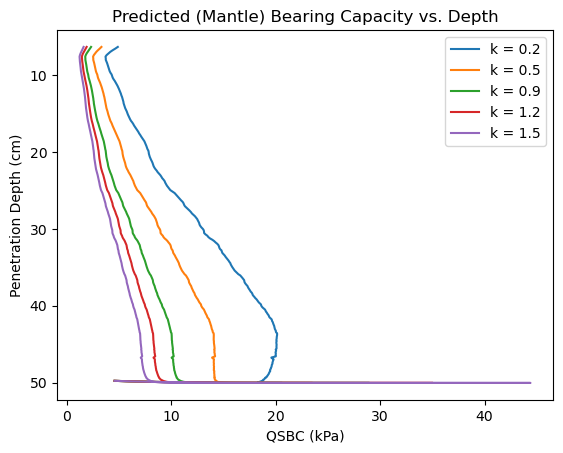

In [187]:
k_factor_vals = [0.2, 0.5, 0.9, 1.2, 1.5]

displacement = drop.impulse_df["displacement"]
df = drop.bearing_dfs["mantle"]

start = 30
# start = 0
end = -1
for val in k_factor_vals:
    column = "qsbc_mant_{}".format(val)
    k_name=  "k = {}".format(val)
    bearing = df[column][start:end]
    bearing = bearing/1e3
    plt.plot(bearing, displacement[start:end] * 100, label= k_name)

# Format the plot
plt.title("Predicted (Mantle) Bearing Capacity vs. Depth")
plt.ylabel("Penetration Depth (cm)")
plt.xlabel("QSBC (kPa)")
plt.gca().invert_yaxis()
plt.legend()

# Save the figure
save = False

if save:
    plt.savefig("Bearing_Plot.png", dpi = 300)

# Show the figure
plt.show()

#### Generate the traditional plot

There's a plan to make this into a function that lets you save the figure. I haven't gotten around to it yet.

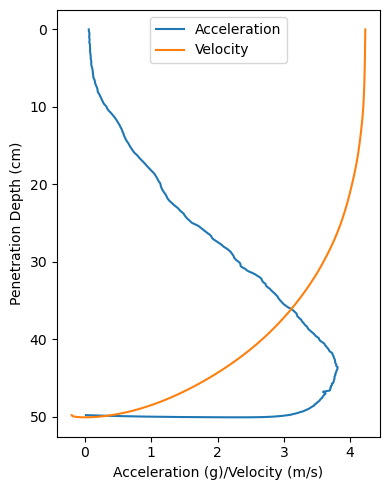

In [188]:
# Store  the data to make it easier to write in the plot function
df = drop.impulse_df
time = df["Time"]
accel = df["accel"]/9.81
displacement =  df["displacement"] * 100
velocity = df["velocity"]

# Create the subplot
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (4,5))

# Make axs into an array to make indexing easier
axs = np.atleast_1d(axs)

# Plot the data
axs[0].plot(accel, displacement, label = "Acceleration")
axs[0].plot(velocity, displacement, label = "Velocity")

# Format the plot
axs[0].set_xlabel("Acceleration (g)/Velocity (m/s)")
axs[0].set_ylabel("Penetration Depth (cm)")
axs[0].invert_yaxis()
axs[0].legend()

plt.tight_layout()

# Save the figure 
save = False
if save: 
    axs[0].savefig("accel_depth profile")

plt.show()

#### Generating the traditional plot at the file level

There's also a function at the file level that can generate the acceleration/velocity plot for all of the drops in the file.

**Note:** this function is going to be changed in the future so the plotting happens at the drop level and then this function just calls the drop function.

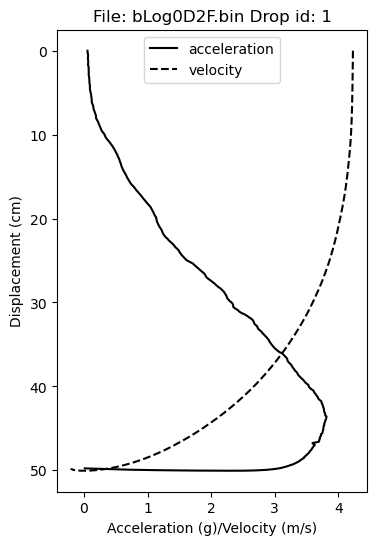

In [189]:
file.plot_drop_impulses(figsize = [4,6], save_figs = False, hold = False, legend = True,
                        colors = ["black", "blue", "green", "orange", "purple", "brown"],
                        units = {"Time":"s", "accel":"g", "velocity":"m/s", "displacement":"cm"},
                        line_style = ["solid", "dashed"])